In [1]:
import os
import keras.backend as K
import numpy as np
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from keras.layers import add
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from skimage.transform import rescale, resize
from skimage import io
from sklearn.model_selection import train_test_split
from scipy.misc import imresize
from skimage import data
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
# %%capture
from tqdm import tqdm_notebook as tqdm
from time import sleep
tqdm().pandas()

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Network Architecture
![title](network.jpg)

As we can see the Vanilla Generator consists of:

    1. Conv2d (k9n64s1), followed by PReLU
    2. 16 residual blocks consisting of Conv2d, BN, PReLU and BN with an element wise sum
    3. Another copnv2d, BN and element wise sum
    4. 2 upsample blocks consisting of deconvolution 
    4. One last conv layer k9n3s1
    5. Activated on say 'tan'

We will code this generator for the default implementation


In [2]:
def gen_res_blocks(m, k, f, s):
    gen = m
    
    m = Conv2D(filters = f, kernel_size = k, strides = s, padding='same')(m)
    m = BatchNormalization(momentum = 0.5)(m)
    
    #using PReLU
    m = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(m)
    m = Conv2D(filters = f, kernel_size= k, strides = s, padding='same')(m)
    m = BatchNormalization(momentum = 0.5)(m)
    
    m = add([gen, m])
    
    return m

def gen_upsampling_block(m, k, f, s):
    m = Conv2D(filters=f, kernel_size=k, strides=s, padding='same')(m)
    m = UpSampling2D(size = 2)(m)
    m = LeakyReLU(alpha=0.2)(m)
    
    return m

def create_generator(noise_shape):
    gen_input = Input(shape=noise_shape)
    
    model = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(gen_input)
    
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    
    gen_model = model
    
    # 16 residual blocks
    for i in range(16):
        model = gen_res_blocks(model, 3, 64, 1)
    
    model = Conv2D(filters = 64, kernel_size = 3, strides=1, padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)
    model = add([gen_model, model])
    
    # 2 upsampling blocks
    for i in range(2):
        model = gen_upsampling_block(model, 3, 256, 1)
        
    # final conv layer
    model = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(model)
    model = Activation('tanh')(model)
    
    generator_model = Model(inputs = gen_input, output = model)
    
    return generator_model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 56, 56, 64)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 64)   36928       p_re_lu_1[0][0]                  
_____________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


None

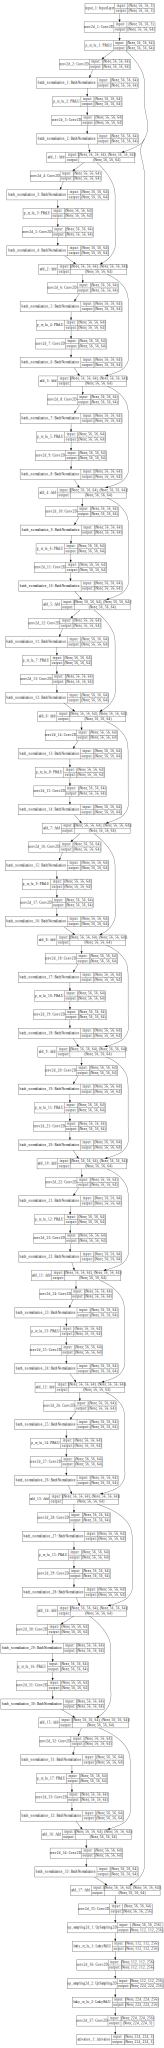

In [4]:
model = create_generator((56,56,3))
display(model.summary())
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [3]:
## discrtiminator network

def get_dis_block(m, f, k, s):
    m = Conv2D(filters=f, kernel_size=k, strides=s, padding='same')(m)
    m = BatchNormalization(momentum=0.5)(m)
    m = LeakyReLU(alpha=0.2)(m)
    
    return m
    


def create_discriminator(image_shape):
    dis_input = Input(shape=image_shape)
    
    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
    model = LeakyReLU(alpha = 0.2)(model)
    
    model = get_dis_block(model, 64, 3, 2)
    model = get_dis_block(model, 128, 3, 1)
    model = get_dis_block(model, 128, 3, 2)
    model = get_dis_block(model, 256, 3, 1)
    model = get_dis_block(model, 256, 3, 2)
    model = get_dis_block(model, 512, 3, 1)
    model = get_dis_block(model, 512, 3, 2)
    
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)
    
    discriminator_model = Model(inputs = dis_input, outputs = model)
    
    return discriminator_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

None

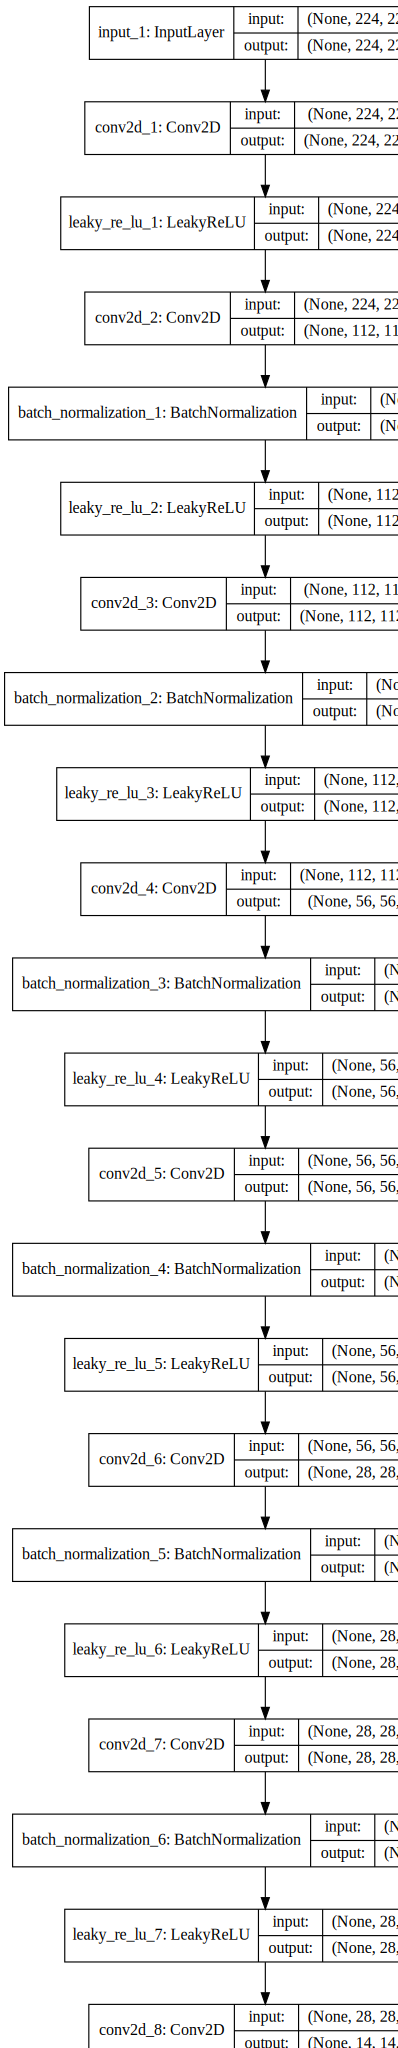

In [4]:
dis_model = create_discriminator((224,224,3))
display(dis_model.summary())
SVG(model_to_dot(dis_model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

## Mounting Google Drive -- Run only if needed

Not necessary for testing

In [ ]:
import zipfile
# unzip images
if not os.path.isdir("data"):
  os.mkdir('data')

if not os.path.isdir("gen_samples"):
  os.mkdir('gen_samples')

if not os.path.isdir("drive/My Drive/Colab Notebooks/AML_SR_GAN"):
  os.mkdir('drive/My Drive/Colab Notebooks/AML_SR_GAN')
zip_ref_1 = zipfile.ZipFile("drive/My Drive/Colab Notebooks/train_imgs1.zip", 'r')
zip_ref_2 = zipfile.ZipFile("drive/My Drive/Colab Notebooks/AML_SR_GAN/train_imgs2.zip", 'r')
zip_ref_1.extractall('data')
zip_ref_2.extractall('data')
zip_ref_1.close()
zip_ref_2.close()

# UTILITY METHODS

In [5]:
from PIL import Image

def normalize(input_data):
    return (input_data.astype(np.float32) - 127.5)/127.5 

def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)

def get_images(img_dir, train_test_ratio, number_images):
    # load all images from the img_dir
    hr, lr = [], []
    images = []
    count = 1
    for f in os.listdir(img_dir):
        if os.path.isfile(os.path.join(img_dir, f)):
            # reads img file as numpy array
            img = data.imread(os.path.join(img_dir, f))
            # resize iamge to 224, 224 after checking it is larger than or queal to 224,224
            images.append(img)
        
        if count == number_images:
            break
        else:
            count += 1
            
    # shuffle images
    images = shuffle(images)
    
    
    for img in images:
      if img.shape[0] >= 224 and img.shape[1] >= 224:
        img_hr = imresize(img, [224, 224], interp='bicubic', mode=None)
        img_lr = imresize(img_hr, [img_hr.shape[0]//4, img_hr.shape[1]//4], interp='bicubic', mode=None)

        hr.append(img_hr)
        lr.append(img_lr)
        
        
    # split the images into train and test
    hr_norm = normalize(np.array(hr))
    lr_norm = normalize(np.array(lr))
    partition_index = int(len(hr) * train_test_ratio)
    test_hr, train_hr = hr_norm[:partition_index], hr_norm[partition_index:]
    test_lr, train_lr  = lr_norm[:partition_index], lr_norm[partition_index:]
    
    return np.array(train_hr), np.array(train_lr), np.array(test_hr), np.array(test_lr)

    
def plot_generated_image(img_hr, img_lr, save_dir, generator, epoch):
    
    gen_image = generator.predict(img_lr)
    
    # pick a random image to show
    rand_ind = np.random.randint(0, img_hr.shape[0])
    
    # may need to denromalize images here
    img_hr_de, img_lr_de = denormalize(img_hr), denormalize(img_lr)
    gen_image_de = denormalize(gen_image)
    
  
    dim = (1, 3)
    plt.figure(figsize=(10, 10))
    
    ax0 = plt.subplot(dim[0], dim[1], 1)
    ax0.set_title('LR Image')
    io.imshow(img_lr_de[rand_ind])
    plt.axis('off')
        
    ax1 = plt.subplot(dim[0], dim[1], 2)
    ax1.set_title('SR Gan Image')
    io.imshow(gen_image_de[rand_ind])
    plt.axis('off')
    
    ax2 = plt.subplot(dim[0], dim[1], 3)
    ax2.set_title('HR Image')
    io.imshow(img_hr_de[rand_ind])
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_dir + '/generated_image_%d.png' % epoch)
    plt.show()
    
    

def plot_all_images(generator, save_dir, 
                    test_images=None, img_dir=None):
  
  # make saving dir if it does not exist
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
  
  if img_dir is not None:
    img_count = 0
    lr = []
    hr = []
    for f in os.listdir(img_dir):
      if os.path.isfile(os.path.join(img_dir, f)):
        img = data.imread(os.path.join(img_dir, f))
        # chekc if we have hr image
        if img.shape[0] >= 224 and img.shape[1] >= 224:
          hr.append(img)
        # resize to low res just in case
        img_lr = imresize(img, [56, 56], interp='bicubic', mode=None)
        lr.append(img_lr)
        img_count += 1
    print(img_count, ' images read from: ', img_dir)
    # plotting the lr and gen sr image:
    
    # denormalizing the shape
    lr_norm = normalize(np.array(lr))
    sr_im = generator.predict(lr_norm)
    sr_im_de = denormalize(sr_im)
    
    #we have same number of hr and lr images otherwise plotting code will break
    if len(hr) == len(lr):
      hr_norm = np.array(hr)
      print(hr_norm.shape)
    
    for i, im in enumerate(lr):
      
      if hr_norm is None:
        dim = (1, 2)
      else:
        dim = (1, 3)
      
      plt.figure(figsize=(10, 10))
      
      ax0 = plt.subplot(dim[0], dim[1], 1)
      ax0.set_title('LR Image')
      io.imshow(im)
      plt.axis('off')
      
      ax1 = plt.subplot(dim[0], dim[1], 2)
      ax1.set_title('SR Gan Image')
      
      # saving the generated images separately as well
      im = Image.fromarray(sr_im_de[i])
      im.save(save_dir + "/single_gen_img_{0}.jpg".format(i))
      
      io.imshow(sr_im_de[i])
      plt.axis('off')
      
      if dim[1] == 3:
        # we have hr image as well
        ax2 = plt.subplot(dim[0], dim[1], 3)
        ax2.set_title('HR Image')
        io.imshow(hr_norm[i])
        plt.axis('off')
      
      plt.tight_layout()
      plt.savefig(save_dir + '/generated_image_%d.png' % i)
      plt.show()
      
      
      
      
  elif test_images is not None:
    print('We have the test images passed in rather than the dir')
    hr, lr = test_images[0], test_images[1]
    # assuming the lr and hr images passed are normalized
    gen_image = generator.predict(lr)
    # denormalizing the images
    img_hr_de, img_lr_de, gen_image_de = denormalize(hr), denormalize(lr), denormalize(gen_image)
    img_index = 0
    for h_img, l_img, sr_img in zip(img_hr_de, img_lr_de, gen_image_de):
      
      dim = (1, 3)
      plt.figure(figsize=(10, 10))
    
      ax0 = plt.subplot(dim[0], dim[1], 1)
      ax0.set_title('LR Image')
      io.imshow(l_img)
      
      plt.axis('off')
        
      ax1 = plt.subplot(dim[0], dim[1], 2)
      ax1.set_title("SR Gan Image")
      io.imshow(sr_img)
      
      plt.axis('off')
    
      ax2 = plt.subplot(dim[0], dim[1], 3)
      ax2.set_title("HR Image")
      io.imshow(h_img)
      
      plt.axis('off')
    
      plt.tight_layout()
      plt.savefig(save_dir + '/generated_image_%d.png' % img_index)
    
      # saving the image separately as well
      im = Image.fromarray(sr_img)
      im.save(save_dir + "/single_gen_img_{0}.jpg".format(img_index))
      plt.show()
      
      
      img_index += 1
      

# VGG LOSS

In [6]:
# from keras.applications.vgg19 import VGG19
# import keras.backend as K
# from keras.models import Model
# from keras.optimizers import Adam

def vgg_loss(y_true, y_pred):
    
    image_shape = (224, 224, 3)
    
    vgg19 = VGG19(include_top='false', weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    
    # freeze each layer in 
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False
    
    return K.mean(K.square(model(y_true) - model(y_pred)))

# TRAINING

In [7]:
# def get_gan_network(dis_m, gen_m, ):

def get_gan_network(dis_m, gen_m, shape, opt, vgg_loss):
    dis_m.trainable = False
    gan_input = Input(shape=shape)
    x = gen_m(gan_input)
    gan_output = dis_m(x)
    
    gan = Model(inputs=gan_input, outputs=[x, gan_output])
    
    gan.compile(loss=[vgg_loss, 'binary_crossentropy'], loss_weights=[1, 1e-3], optimizer=opt)
    
    return gan

def train(epochs, batch_size, dataset, save_dir, dis_model_path=None, gen_model_path=None):
    
    x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = dataset[0], dataset[1], dataset[2], dataset[3]
    lr_factor = 4
    
    image_shape_hr = (224, 224, 3)
    image_shape_lr = (image_shape_hr[0]/lr_factor, image_shape_hr[0]/lr_factor, image_shape_hr[2])
    
    generator = create_generator(image_shape_lr)
    if gen_model_path is not None and os.path.isfile(gen_model_path):
      print('Generator weights updated')
      generator.load_weights(gen_model_path)
      
    discriminator = create_discriminator(image_shape_hr)
    if dis_model_path is not None and os.path.isfile(dis_model_path):
      print('Dis model weights updated')
      discriminator.load_weights(dis_model_path)
    
    
    opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    generator.compile(loss=vgg_loss, optimizer=opt)
    discriminator.compile(loss="binary_crossentropy", optimizer=opt)
    
    gan = get_gan_network(discriminator, generator, image_shape_lr, opt, vgg_loss)
    
    
    batch_count = int(len(x_tr_hr)/batch_size)
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            sleep(0.01)
            # training the discriminator first
            rand_nums = np.random.randint(0, x_tr_hr.shape[0], size=batch_size)
            batch_hr = x_tr_hr[rand_nums]
            batch_lr = x_tr_lr[rand_nums]
            gen_im_sr = generator.predict(batch_lr)
            
            real_im_y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_im_y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            real_im_dis_loss = discriminator.train_on_batch(batch_hr, real_im_y)
            fake_im_dis_loss = discriminator.train_on_batch(gen_im_sr, fake_im_y)
            dis_loss = 0.5 * np.add(real_im_dis_loss, fake_im_dis_loss)
            
            ## training the gan now
            rand_nums = np.random.randint(0, x_tr_hr.shape[0], size=batch_size)
            batch_hr = x_tr_hr[rand_nums]
            batch_lr = x_tr_lr[rand_nums]
            
            gan_y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(batch_lr, [batch_hr, gan_y])
            
        print('Dis loss: ', dis_loss)
        print('Gan loss:', gan_loss)
        
        # writing losses to file
        loss_file = open(save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, dis_loss) )
        loss_file.close()
        
        # plotting the images
        if e % 50 == 0 or e% 100 == 0:
            plot_generated_image(x_test_hr, x_test_lr, save_dir, generator, e)
        # save gen and dis model
        if e % 50 == 0:
            generator.save(save_dir + 'gen_model%d.h5' % e)
            discriminator.save(save_dir + 'dis_model%d.h5' % e)
            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Generator weights updated
Dis model weights updated
574717952/574710816 [==============================] - 13s 0us/step
--------------- Epoch 1 ---------------


Instructions for updating:
Use tf.cast instead.

Dis loss:  8.188248634338379
Gan loss: [0.018478934, 0.017113334, 1.3655992]
--------------- Epoch 2 ---------------



Dis loss:  7.923600673675537
Gan loss: [0.019068016, 0.018144006, 0.9240093]
--------------- Epoch 3 ---------------



Dis loss:  8.321916580200195
Gan loss: [0.02338522, 0.022176186, 1.2090342]
--------------- Epoch 4 ---------------



Dis loss:  7.816195964813232
Gan loss: [0.019371923, 0.017857308, 1.5146147]
--------------- Epoch 5 ---------------



Dis loss:  8.00675106048584
Gan loss: [0.021055311, 0.019030884, 2.024427]
--------------- Epoch 6 ---------------



Dis loss:  7.587773323059082
Gan loss: [0.019566422, 0.018395664, 1.1707575]
--------------- Epoch 7 ---------------



Dis loss:  7.8348846435546875
Gan loss: [0.0180298, 0.01714523, 0.88457036]
--------------- Epoch 8 ---------------



Dis loss:  8.104702949523926
Gan loss: [0.013642938, 0.012217495, 1.4254435]
--------------- Epoch 9 ---------------



Dis loss:  7.693414688110352
Gan loss: [0.0124874525, 0.010935168, 1.5522842]
--------------- Epoch 10 ---------------



Dis loss:  8.081208229064941
Gan loss: [0.015748098, 0.014495379, 1.2527196]
--------------- Epoch 11 ---------------



Dis loss:  8.261783599853516
Gan loss: [0.015381577, 0.013405717, 1.9758606]
--------------- Epoch 12 ---------------



Dis loss:  7.853407859802246
Gan loss: [0.015772142, 0.014363772, 1.4083687]
--------------- Epoch 13 ---------------



Dis loss:  7.639849662780762
Gan loss: [0.013773244, 0.012735693, 1.0375514]
--------------- Epoch 14 ---------------



Dis loss:  7.831050872802734
Gan loss: [0.016615244, 0.014883079, 1.7321653]
--------------- Epoch 15 ---------------



Dis loss:  8.00471019744873
Gan loss: [0.01566977, 0.013731018, 1.9387527]
--------------- Epoch 16 ---------------



Dis loss:  7.813770771026611
Gan loss: [0.012627346, 0.0112868985, 1.3404481]
--------------- Epoch 17 ---------------



Dis loss:  7.657569408416748
Gan loss: [0.013935695, 0.012255211, 1.6804843]
--------------- Epoch 18 ---------------



Dis loss:  8.788455963134766
Gan loss: [0.01603111, 0.013910127, 2.1209834]
--------------- Epoch 19 ---------------



Dis loss:  7.910685062408447
Gan loss: [0.012542157, 0.010753954, 1.7882031]
--------------- Epoch 20 ---------------



Dis loss:  7.975212097167969
Gan loss: [0.013875121, 0.012635099, 1.2400227]
--------------- Epoch 21 ---------------



Dis loss:  7.961490154266357
Gan loss: [0.015323961, 0.013746965, 1.5769962]
--------------- Epoch 22 ---------------



Dis loss:  7.73216438293457
Gan loss: [0.012942158, 0.011498854, 1.4433045]
--------------- Epoch 23 ---------------



Dis loss:  8.146868705749512
Gan loss: [0.012185954, 0.010005552, 2.1804006]
--------------- Epoch 24 ---------------



Dis loss:  7.9754109382629395
Gan loss: [0.012567875, 0.010713073, 1.854801]
--------------- Epoch 25 ---------------



Dis loss:  7.934274673461914
Gan loss: [0.011888936, 0.010408812, 1.4801241]
--------------- Epoch 26 ---------------



Dis loss:  8.095224380493164
Gan loss: [0.013428972, 0.012519213, 0.9097591]
--------------- Epoch 27 ---------------



Dis loss:  8.19762897491455
Gan loss: [0.010897978, 0.00932036, 1.5776184]
--------------- Epoch 28 ---------------



Dis loss:  8.234350204467773
Gan loss: [0.014533339, 0.012052531, 2.4808075]
--------------- Epoch 29 ---------------



Dis loss:  8.061880111694336
Gan loss: [0.013177953, 0.01124183, 1.9361225]
--------------- Epoch 30 ---------------



Dis loss:  7.872625827789307
Gan loss: [0.012886043, 0.010836316, 2.0497265]
--------------- Epoch 31 ---------------



Dis loss:  7.6946635246276855
Gan loss: [0.013231221, 0.011920004, 1.3112165]
--------------- Epoch 32 ---------------



Dis loss:  8.08503246307373
Gan loss: [0.011090196, 0.009641811, 1.4483845]
--------------- Epoch 33 ---------------



Dis loss:  8.05176830291748
Gan loss: [0.01262991, 0.011028254, 1.6016562]
--------------- Epoch 34 ---------------



Dis loss:  7.777898788452148
Gan loss: [0.013036214, 0.011486411, 1.549803]
--------------- Epoch 35 ---------------



Dis loss:  7.921998977661133
Gan loss: [0.011515146, 0.009793047, 1.7220994]
--------------- Epoch 36 ---------------



Dis loss:  7.816401481628418
Gan loss: [0.012193152, 0.011189816, 1.0033361]
--------------- Epoch 37 ---------------



Dis loss:  8.315369606018066
Gan loss: [0.011672206, 0.010335448, 1.3367584]
--------------- Epoch 38 ---------------



Dis loss:  7.5867719650268555
Gan loss: [0.010822168, 0.008733091, 2.089077]
--------------- Epoch 39 ---------------



Dis loss:  8.032397270202637
Gan loss: [0.011373785, 0.009758858, 1.6149273]
--------------- Epoch 40 ---------------



Dis loss:  7.732327461242676
Gan loss: [0.010703452, 0.009610076, 1.0933757]
--------------- Epoch 41 ---------------



Dis loss:  7.470303535461426
Gan loss: [0.009934137, 0.008743255, 1.1908808]
--------------- Epoch 42 ---------------



Dis loss:  7.934408187866211
Gan loss: [0.011257276, 0.00987647, 1.3808059]
--------------- Epoch 43 ---------------



Dis loss:  8.128850936889648
Gan loss: [0.010656021, 0.009147224, 1.5087967]
--------------- Epoch 44 ---------------



Dis loss:  7.808529853820801
Gan loss: [0.01166377, 0.009736432, 1.927338]
--------------- Epoch 45 ---------------



Dis loss:  8.223868370056152
Gan loss: [0.009167598, 0.007884217, 1.28338]
--------------- Epoch 46 ---------------



Dis loss:  8.033717155456543
Gan loss: [0.010268416, 0.008698049, 1.570367]
--------------- Epoch 47 ---------------



Dis loss:  8.119902610778809
Gan loss: [0.011394164, 0.009777853, 1.6163106]
--------------- Epoch 48 ---------------



Dis loss:  7.586174011230469
Gan loss: [0.01046811, 0.008386849, 2.0812614]
--------------- Epoch 49 ---------------



Dis loss:  8.14548397064209
Gan loss: [0.013039246, 0.012073688, 0.96555775]
--------------- Epoch 50 ---------------



Dis loss:  7.830747127532959
Gan loss: [0.010152507, 0.008895988, 1.2565186]


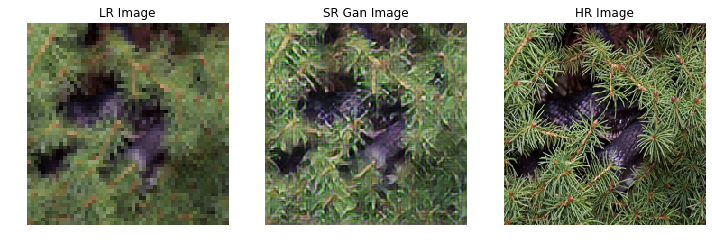

In [ ]:
## BEIGN TRAINING
x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = get_images('data', 0.2, 1400)
# all paths given here

# saved_generator_apth
gen_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN/gen_model50.h5'
# saved discriminator path
dis_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN/dis_model50.h5'
# plotted images target directory
save_dir = 'drive/My Drive/Colab Notebooks/AML_SR_GAN/gen_image_After_100ep/'

train(50, 8, (x_tr_hr, x_tr_lr, x_test_hr, x_test_lr), save_dir=save_dir, gen_model_path=gen_path, dis_model_path=dis_path)

## Run Below Block to Generate Images using pre-trained weights file



*   Pass path of the generator, default is the root directory of code

*   Pass the target directory, for generated images and test imges directory, former need not exist, latter must, obviously

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:104: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


4  images read from:  ../report_images
(4, 224, 224, 3)


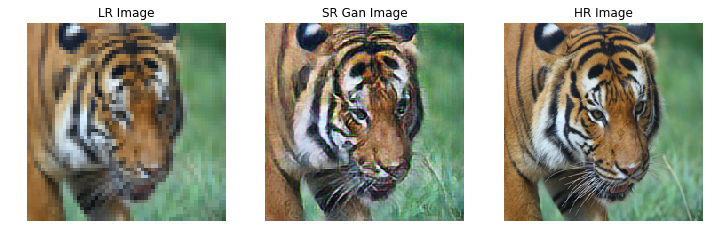

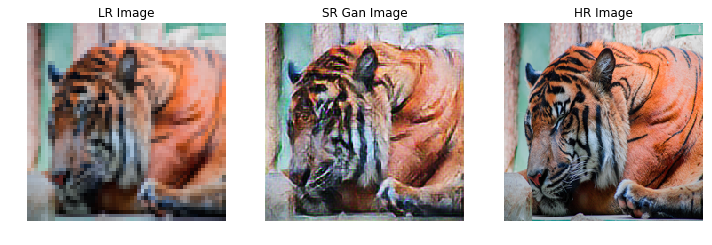

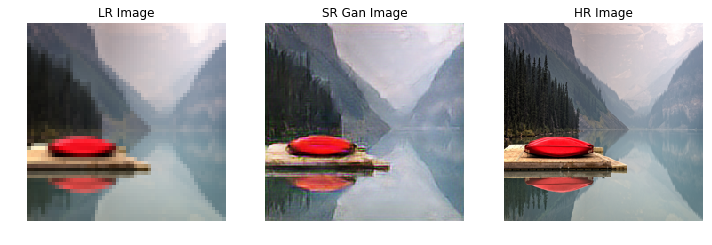

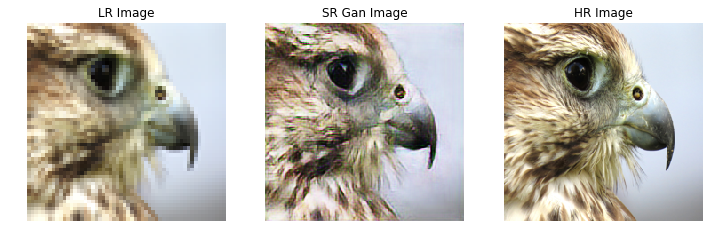

In [10]:
# # loading the generator
from keras.models import load_model
# gen_path = "drive/My Drive/Colab Notebooks/AML_SR_GAN//gen_model1000.h5"
gen_path = "gen_model1000.h5"
gen = create_generator((56, 56, 3))
gen.load_weights(gen_path)

# loading images to be put into fking report
# img_dir = "drive/My Drive/Colab Notebooks/AML_SR_GAN/report_images"
# save_dir = "drive/My Drive/Colab Notebooks/AML_SR_GAN/Gen_Img_report/imgs_after_1000ep_2"
img_dir = "../report_images"
save_dir = "gen_images"
plot_all_images(gen, save_dir, img_dir=img_dir)